<img style="max-width:20em; height:auto;" src="../graphics/A-Little-Book-on-Adversarial-AI-Cover.png"/>

Author: Nik Alleyne   
Author Blog: https://www.securitynik.com   
Author GitHub: github.com/securitynik   

Author Other Books: [   

            "https://www.amazon.ca/Learning-Practicing-Leveraging-Practical-Detection/dp/1731254458/",   
            
            "https://www.amazon.ca/Learning-Practicing-Mastering-Network-Forensics/dp/1775383024/"   
        ]   


This notebook ***(mal_net_tiny_gnn.ipynb)*** is part of the series of notebooks From ***A Little Book on Adversarial AI***  A free ebook released by Nik Alleyne

### Malware Classification with Graph Neural Network

### Lab Objectives:  
- Use a Graph Convolutional Network (GNN) for malware classification   
- Understand how to build a Graph Convolutional Network (GNN)   
- Understand the capabilities of a Graph Neural Network  


### Step 1:   
Get the data   

In [1]:
# Import the needed libraries
import torch
import torch.nn as nn
import torch_geometric
from torch_geometric.datasets import MalNetTiny
from torch_geometric.transforms import BaseTransform
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F

from tqdm import tqdm

import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

import sklearn
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors

In [2]:
### Version of key libraries used  
print(f'Torch version used:  {torch.__version__}')
print(f'Torch_geometric version used:  {torch_geometric.__version__}')
print(f'Sklearn version used:  {sklearn.__version__}')

Torch version used:  2.7.1+cu128
Torch_geometric version used:  2.6.1
Sklearn version used:  1.7.0


In [3]:
# Setup the device to work with
# This should ensure if there are accelerators in place, such as Apple backend or CUDA, 
# we should be able to take advantage of it.

if torch.cuda.is_available():
    print('Setting the device to cuda')
    device = 'cuda'
elif torch.backends.mps.is_available():
    print('Setting the device to Apple mps')
    device = 'mps'
else:
    print('Setting the device to CPU')
    device = torch.device('cpu')

Setting the device to cuda


Because of the way the dataset si setup, we need some dummy features. Let's create a class to help with this transformation. We will need to subclass the BaseTransform class that was imported above   


In [4]:
# This class addresses an issue in the dataset where there is no data.x
class AddNodeFeaturesTransform(BaseTransform):
    def __init__(self, value=1.0, dim=1):
        self.value = value
        self.dim = dim

    def __call__(self, data):
        data.x = torch.full(size=(data.num_nodes, self.dim), fill_value=self.value)
        return data

In [5]:
# Setup the transform
transform = AddNodeFeaturesTransform()
transform

AddNodeFeaturesTransform()

In [6]:
# Set the manual seed to ensure reproducibility  
torch.manual_seed(seed=10)

# Load the train dataset, while leveraging the transform
train_dataset = MalNetTiny(root='/tmp', split='train', transform=transform)
# Shuffle the dataset
train_dataset = train_dataset.shuffle(return_perm=False)
print(f'The train dataset has: {train_dataset}')

# Load the test dataset while leveraging the transform
test_dataset = MalNetTiny(root='/tmp', split='test', transform=transform)
test_dataset = test_dataset.shuffle(return_perm=False)
print(f'The test dataset has: {test_dataset}')


Extracting /tmp/raw/malnet-graphs-tiny.tar.gz
Extracting /tmp/raw/split_info_tiny.zip
Processing...
Done!


The train dataset has: MalNetTiny(3500)
The test dataset has: MalNetTiny(1000)


In [7]:
# Setup a batch size:
batch_size = 64 

# Setup the train dataloader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
print(f'Data has: {next(iter(train_loader)).edge_index.shape[1]} features')

# Setup the test dataloader
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
print(f'Data has: {next(iter(test_loader)).edge_index.shape[1]} features')


Data has: 153384 features
Data has: 175227 features


### Step 2:   
Build the Graph Convolutional Network (GCN)

In [8]:
# Define some hyper parameters
hidden_channels = 64
num_classes = train_dataset.num_classes

In [9]:
# Get the actual classes
# Malware labels
malware_labels = ['addisplay', 'adware', 'benign', 'downloader', 'trojan']
malware_labels

['addisplay', 'adware', 'benign', 'downloader', 'trojan']

In [10]:
class GCN(nn.Module):
    def __init__(self, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels=train_dataset.num_features, out_channels=hidden_channels, bias=True)
        self.conv2 = GCNConv(in_channels=hidden_channels, out_channels=hidden_channels, bias=True)
        self.fc1 = nn.Linear(in_features=hidden_channels, out_features=num_classes)

    def forward(self, x, edge_index, batch):
        # Pass the x through the first GCNConv followed by a ReLU activation
        x = F.relu(self.conv1(x, edge_index))

        # Pass through the second GCN layer
        x = self.conv2(x, edge_index)

        # Pass the data through the global mean pool layer
        # Aggregate the node embeddings into graph embeddings
        x = global_mean_pool(x=x, batch=batch)
        
        return self.fc1(x)

In [11]:
# Call the untrained model to test it works
model = GCN(hidden_channels=hidden_channels, num_classes=num_classes).to(device=device)
model

GCN(
  (conv1): GCNConv(1, 64)
  (conv2): GCNConv(64, 64)
  (fc1): Linear(in_features=64, out_features=5, bias=True)
)

In [12]:
# Run the data through the untrained model 
# Just look at the first 5 results 
model(x=next(iter(train_loader)).x.to(device=device), edge_index=next(iter(train_loader)).edge_index.to(device), batch=next(iter(train_loader)).batch.to(device) )[:5]

tensor([[ 0.1584,  0.0141,  0.4510, -0.1608, -0.1443],
        [ 0.1603,  0.0144,  0.4626, -0.1693, -0.1483],
        [ 0.1487,  0.0126,  0.3941, -0.1192, -0.1244],
        [ 0.1554,  0.0136,  0.4336, -0.1481, -0.1382],
        [ 0.1502,  0.0128,  0.4030, -0.1256, -0.1275]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [13]:
# Define our optimize 
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

# Setup the loss function
loss_fn = nn.CrossEntropyLoss()

In [14]:
# Setup a train function
def train(loader=train_loader):
    model.train()
    total_loss = 0.

    for data in loader:
        data = data.to(device)
        optimizer.zero_grad(set_to_none=True)
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fn(input=out, target=data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        break
    return total_loss / len(loader.dataset)
        

In [15]:
# Setup a function evaluate the model during training
@torch.no_grad()
def evaluate(loader=test_loader):
    model.eval()
    correct = 0

    for data in test_loader:
        data = data.to(device=device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    return correct / len(loader.dataset)

In [16]:
@torch.no_grad()
def get_graph_embeddings(model=model, loader=test_loader, device=device):
    model.eval()
    embeddings = []
    labels = []

    for data in loader:
        data = data.to(device=device)
        out = model.conv1(data.x, data.edge_index)
        out = torch.relu(out)
        out = model.conv2(out, data.edge_index)
        pooled = torch_geometric.nn.global_mean_pool(out, data.batch)
        embeddings.append(pooled.cpu())
        labels.append(data.y.cpu())

    return torch.cat(embeddings), torch.cat(labels)


In [17]:
# Setup a function to visualize the embeddings
def visualize_embeddings(embeddings, labels, title='Graph Embeddings'):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embd_2d = tsne.fit_transform(X=embeddings)

    # Get te unique classes
    classes = sorted(set(labels))
    num_classes = len(classes)

    # Setup a custom colour bar
    cmap = plt.get_cmap(name='tab10', lut=num_classes)
    norm = mcolors.BoundaryNorm(boundaries=range(num_classes + 1), ncolors=num_classes)

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(x=embd_2d[:, 0], y=embd_2d[:, 1], c=labels, cmap=cmap, norm=norm, s=10, alpha=0.8)
    cbar = plt.colorbar(scatter, ticks=range(num_classes))
    cbar.set_label('Class Label')
    cbar.set_ticklabels([c for c in malware_labels])
    
    plt.title(label=f'{title}')
    plt.xlabel(xlabel='t-SNE Dimension 1')
    plt.ylabel(ylabel='t-SNE Dimension 2')
    plt.grid(visible=True, axis='both')
    plt.tight_layout()
    plt.show()

In [18]:
# Get the number of epochs
# Not building a model to deploy. 
# However you can adjust the number of epochs for your environment
n_epochs = 10

# Train the model
print(f'Training ... ')
for epoch in range(n_epochs):
    loss = train()
    val_accuracy = evaluate(loader=test_loader)

print(f'Finished training ... ')

Training ... 
Finished training ... 


In [19]:
# Get the test accuracy
test_accuracy = evaluate(loader=test_loader)
print(f'Test Accuracy: {test_accuracy :.4f}')

Test Accuracy: 0.2000


In [20]:
# Get the graph embeddings and labels
graph_embedding, labels = get_graph_embeddings(model=model, loader=test_loader, device=device )

graph_embedding[:1], labels[:1]

(tensor([[ 0.1273, -0.0372,  0.1070,  0.0094, -0.1377,  0.0261,  0.1307,  0.0614,
           0.0442,  0.2015, -0.0436, -0.0721, -0.0710, -0.0878, -0.0311,  0.0588,
           0.1082, -0.0856, -0.0016,  0.0365,  0.0896,  0.0099, -0.0055, -0.0152,
           0.1011,  0.0312,  0.2252, -0.1017, -0.3557,  0.0130,  0.0616,  0.1117,
           0.0932,  0.0852,  0.0142,  0.0633, -0.0821, -0.0311, -0.0206, -0.1652,
           0.0882, -0.0626,  0.0416, -0.1086, -0.0326,  0.0817, -0.0652, -0.1790,
          -0.0771, -0.0853,  0.1273, -0.0337, -0.1126, -0.0541, -0.0852,  0.1120,
          -0.0223,  0.1621,  0.0858,  0.1008,  0.0033,  0.0667, -0.0223, -0.0598]]),
 tensor([2]))

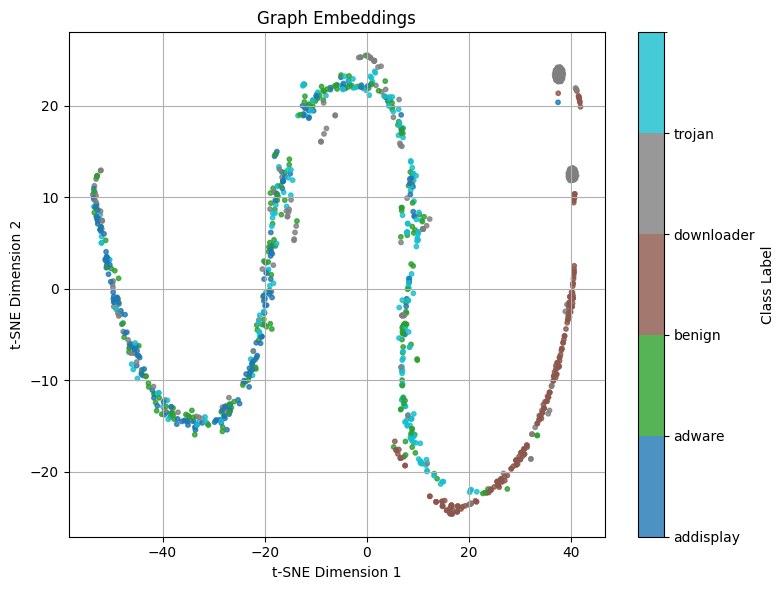

In [21]:
# Visualize the graph
visualize_embeddings(embeddings=graph_embedding.numpy(), labels=labels.numpy())

In [22]:
# Get the node embeddings  
@torch.no_grad()
def get_node_embeddings(model, loader, device, max_graphs=5):
    model.eval()
    all_embeddings = []
    all_labels = []

    graph_count = 0
    for data in loader:
        data = data.to(device)

        if graph_count >= max_graphs:
            break

        x = model.conv1(data.x, data.edge_index)
        x = torch.relu(x)
        x = model.conv2(x, data.edge_index)

        # Get the node level embeddings
        all_embeddings.append(x.cpu())
        
        # Store graph labels for each node in the batch
        graph_labels = data.y[data.batch].cpu()
        all_labels.append(graph_labels)

        graph_count += data.num_graphs

    return torch.cat(all_embeddings), torch.cat(all_labels)

In [23]:
# 
def visualize_node_embeddings(embeddings, labels, title='Node Embeddings'):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embd_2d = tsne.fit_transform(embeddings)

    classes = sorted(set(labels.tolist()))
    num_classes = len(classes)

    cmap = plt.get_cmap(name='tab10', lut=num_classes)
    norm = plt.Normalize(vmin=min(classes), vmax=max(classes))

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(x=embd_2d[:, 0], y=embd_2d[:,1], c=labels, cmap=cmap, norm=norm, s=8, alpha=.7)

    char = plt.colorbar(scatter, ticks=classes)
    char.set_label('Graph Label (node belongs to )')
    char.set_ticklabels(ticklabels=[c for c in malware_labels] )

    plt.title(title)
    plt.xlabel('t-SNE Dim 1')
    plt.ylabel('t-SNE Dim 2')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [24]:
node_embds, node_labels = get_node_embeddings(model=model, loader=test_loader, device=device, max_graphs=5)

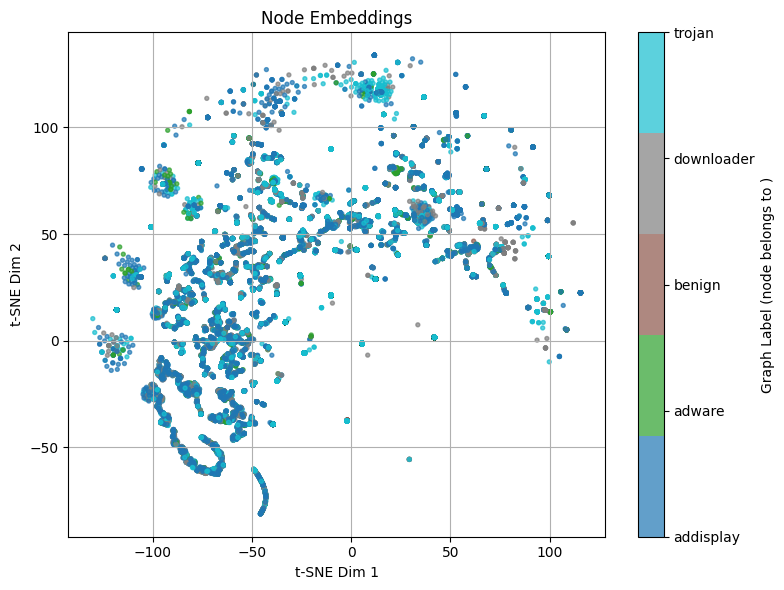

In [25]:
visualize_node_embeddings(embeddings=node_embds.numpy(), labels=node_labels.numpy())

In [26]:
# With a model that we believe is well trained, let's save the model   

In [27]:
pred_logits = model(next(iter(test_loader)).x.to(device), next(iter(test_loader)).edge_index.to(device), next(iter(test_loader)).batch.to(device))
predictions = pred_logits.argmax(dim=-1)
predictions

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')

In [28]:
# With the training finish clear the GPU cache
# Setup the device to work with
if torch.cuda.is_available():
    # For CUDA GPU
    print(f'Cleaning {device} cache')
    torch.cuda.empty_cache()
elif torch.backends.mps.is_available():
    # For Apple devices
    print(f'Cleaning {device} cache')
    torch.mps.empty_cache()
else:
    # Default to cpu
    pass

Cleaning cuda cache


### Lab Takeaways:  
- This was just to show that there are many different ways of building neural networks for any particular task  
- In this case we used a Graph Neural Network (GNN)

References:   
- https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.MalNetTiny.html   